# 迁移学习

现在，我们来学习如何使用预训练的网络解决有挑战性的计算机视觉问题。你将使用通过 [ImageNet](http://www.image-net.org/) [位于 torchvision 上](http://pytorch.org/docs/0.3.0/torchvision/models.html)训练的网络。 

ImageNet 是一个庞大的数据集，包含 100 多万张有标签图像，并涉及 1000 个类别。.它可用于训练采用卷积层结构的深度神经网络。我不会详细讲解卷积网络，但是你可以观看[此视频](https://www.youtube.com/watch?v=2-Ol7ZB0MmU)了解这种网络。

训练过后，作为特征检测器，这些模型可以在训练时未使用的图像上达到惊人的效果。对不在训练集中的图像使用预训练的网络称为迁移学习。我们将使用迁移学习训练网络分类猫狗照片并达到很高的准确率。

使用 `torchvision.models`，你可以下载这些预训练的网络，并用在你的应用中。我们现在导入 `models`。

In [14]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import helper

大多数预训练的模型要求输入是 224x224 图像。此外，我们需要按照训练时采用的标准化方法转换图像。每个颜色通道都分别进行了标准化，均值为 `[0.485, 0.456, 0.406]`，标准偏差为 `[0.229, 0.224, 0.225]`。

In [15]:
data_dir = 'Cat_Dog_data'

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


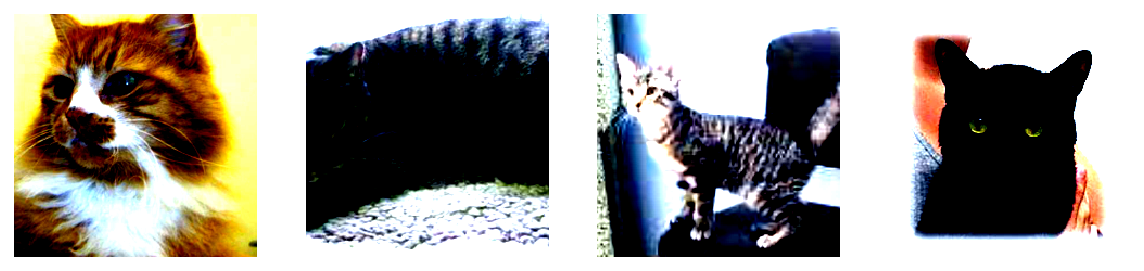

In [16]:
data_iter = iter(testloader)
images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    helper.imshow(images[ii], ax=ax, normalize=False)

我们可以加载 [DenseNet](http://pytorch.org/docs/0.3.0/torchvision/models.html#id5) 等模型。现在我们输出这个模型的结构，看看后台情况。

In [17]:
model = models.densenet121(pretrained=True)
#model

该模型由两部分组成：特征和分类器。特征部分由一堆卷积层组成，整体作为特征检测器传入分类器中。分类器是一个单独的全连接层 `(classifier): Linear(in_features=1024, out_features=1000)`。这个层级是用 ImageNet 数据集训练过的层级，因此无法解决我们的问题。这意味着我们需要替换分类器。但是特征就完全没有问题。你可以把预训练的网络看做是效果很好地的特征检测器，可以用作简单前馈分类器的输入。

In [18]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

In [19]:
#model

构建好模型后，我们需要训练分类器。但是，问题是，现在我们使用的是**非常深度**的神经网络。如果你正常地在 CPU 上训练此网络，这会耗费相当长的时间。所以，我们将使用 GPU 进行运算。在 GPU 上，线性代数运算同步进行，这使得运算速度提升了 100 倍。我们还可以在多个 GPU 上训练，进一步缩短训练时间。

PyTorch 和其他深度学习框架一样，也使用 [CUDA](https://developer.nvidia.com/cuda-zone) 在 GPU 上高效地进行前向和反向运算。在 PyTorch 中，你需要使用 `model.to('cuda')` 将模型参数和其他张量转移到 GPU 内存中。你可以使用 `model.to('cpu')` 将它们从 GPU 移到 CPU，比如在你需要在 PyTorch 之外对网络输出执行运算时。为了向你展示速度的提升对比，我将分别使用 GPU 和不使用 GPU 进行前向和反向传播运算。

In [20]:
import time

In [21]:
torch.cuda.is_available()

True

In [22]:
for device in ['cpu', 'cuda']:#'cuda'

    criterion = nn.NLLLoss()
    # Only train the classifier parameters, feature parameters are frozen
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

    model.to(device)

    for ii, (inputs, labels) in enumerate(trainloader):
        print("ii:",ii)
        # Move input and label tensors to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        start = time.time()

        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if ii==3:
            break
        
    print(f"Device = {device}; Time per batch: {(time.time() - start)/3:.3f} seconds")

ii: 0
ii: 1
ii: 2
ii: 3
Device = cpu; Time per batch: 0.286 seconds
ii: 0
ii: 1
ii: 2
ii: 3
Device = cuda; Time per batch: 0.006 seconds


你可以先询问 GPU 设备是否可用，如果启用了 CUDA，它将自动使用 CUDA：

at beginning of the script
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

...

then whenever you get a new Tensor or Module
this won't copy if they are already on the desired device
input = data.to(device)
model = MyModule(...).to(device)

接下来由你来完成模型训练过程。流程和之前的差不多，但是现在模型强大了很多，你应该能够轻松地达到 95% 以上的准确率。

>**练习：**请训练预训练的模型来分类猫狗图像。你可以继续使用 DenseNet 模型或尝试 ResNet，两个模型都值得推荐。记住，你只需要训练分类器，特征部分的参数应保持不变。


```python
## TODO: Use a pretrained model to classify the cat and dog images
```

In [23]:
def test_model(my_model,my_device, my_epochs, my_trainloader, my_testloader):
    steps = 0
    running_loss = 0
    print_every = 5
    
    my_criterion = nn.NLLLoss()
    my_optimizer = optim.Adam(my_model.classifier.parameters(),lr=0.003)

    my_model.to(device)

    for epoch in range(my_epochs):
        for inputs,labels in my_trainloader:
            steps += 1
            inputs,labels = inputs.to(my_device),labels.to(my_device)

            my_optimizer.zero_grad()
            logps = my_model.forward(inputs)
            loss = my_criterion(logps, labels)
            loss.backward()
            my_optimizer.step()

            running_loss += float(loss.item())
            del inputs
            del labels

            if steps%print_every == 0:
                test_loss = 0
                accuracy = 0
                my_model.eval()
                with torch.no_grad():
                    for inputs,labels in my_testloader:
                        inputs,labels = inputs.to(my_device),labels.to(my_device)
                        logps = my_model.forward(inputs)
                        batch_loss = my_criterion(logps, labels)

                        test_loss += float(batch_loss.item())

                        #Caculate accuracy
                        ps = torch.exp(logps)
                        top_p, top_class = ps.topk(1,dim=1)
                        equals = top_class == labels.view(*top_class.shape)
                        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

                print(f"Epoch {epoch+1}/{my_epochs}.. "
                      f"step: {steps}..."
                      f"Train loss: {running_loss/print_every:.3f}.. "
                      f"Test loss: {test_loss/len(my_testloader):.3f}.. "
                      f"Test accuracy: {accuracy/len(my_testloader):.3f}")
                running_loss = 0
                if accuracy/len(testloader) > 0.94:
                    torch.cuda.empty_cache()
                    break
                my_model.train()
           
    torch.cuda.empty_cache()
                    

In [24]:
torch.cuda.empty_cache()

In [25]:
import time
# at beginning of the script
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [26]:
model_type = models.densenet121(pretrained=True)
#model_type

In [27]:
for param in model_type.parameters():
    param.requires_grad = False
    
model_type.classifier = nn.Sequential(nn.Linear(1024,256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256,2),
                                 nn.LogSoftmax(dim=1))
#model_type

In [28]:
EPOCHS = 1
start = time.time()
test_model(model_type,device,EPOCHS,trainloader,testloader)
print(f"Device = {device}; model_type='densenet121',Time per batch: {(time.time() - start):.3f} seconds")

Epoch 1/1.. step: 5...Train loss: 0.926.. Test loss: 0.260.. Test accuracy: 0.964
Device = cuda:0; model_type='densenet121',Time per batch: 45.316 seconds


In [29]:
model_type = models.alexnet(pretrained=True)
#model_type

In [30]:
for param in model_type.parameters():
    param.requires_grad = False
    
model_type.classifier = nn.Sequential(nn.Linear(9216,4096),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(4096,256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256,2),
                                 nn.LogSoftmax(dim=1))
#model_type

In [31]:
torch.cuda.empty_cache()
torch.cuda.empty_cache()

In [32]:
EPOCHS = 1

start = time.time()
test_model(model_type,device,EPOCHS,trainloader,testloader)
print(f"Device = {device}; model_type='resnet',Time per batch: {(time.time() - start)/1:.3f} seconds")

RuntimeError: CUDA out of memory. Tried to allocate 144.00 MiB (GPU 0; 1.95 GiB total capacity; 1.45 GiB already allocated; 47.00 MiB free; 1.48 GiB reserved in total by PyTorch) (malloc at /pytorch/c10/cuda/CUDACachingAllocator.cpp:289)
frame #0: c10::Error::Error(c10::SourceLocation, std::string const&) + 0x46 (0x7f657811e536 in /home/leon/anaconda3/lib/python3.7/site-packages/torch/lib/libc10.so)
frame #1: <unknown function> + 0x1cf1e (0x7f6578367f1e in /home/leon/anaconda3/lib/python3.7/site-packages/torch/lib/libc10_cuda.so)
frame #2: <unknown function> + 0x1df9e (0x7f6578368f9e in /home/leon/anaconda3/lib/python3.7/site-packages/torch/lib/libc10_cuda.so)
frame #3: THCStorage_resize + 0x96 (0x7f6579607c26 in /home/leon/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #4: at::native::(anonymous namespace)::resize_cuda_(at::Tensor&, c10::ArrayRef<long>, c10::optional<c10::MemoryFormat>) + 0x9aa (0x7f657ae1e69a in /home/leon/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #5: <unknown function> + 0x28a5633 (0x7f657ae1f633 in /home/leon/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #6: <unknown function> + 0xf3a832 (0x7f65794b4832 in /home/leon/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #7: <unknown function> + 0x106c436 (0x7f65795e6436 in /home/leon/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #8: <unknown function> + 0xf8f868 (0x7f6579509868 in /home/leon/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #9: <unknown function> + 0x10c3ec0 (0x7f65b0eefec0 in /home/leon/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #10: <unknown function> + 0x2c9b6fe (0x7f65b2ac76fe in /home/leon/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #11: <unknown function> + 0x10c3ec0 (0x7f65b0eefec0 in /home/leon/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #12: at::Tensor::mm(at::Tensor const&) const + 0xf0 (0x7f65b0ab3b70 in /home/leon/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #13: <unknown function> + 0x28e6b6c (0x7f65b2712b6c in /home/leon/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #14: torch::autograd::generated::AddmmBackward::apply(std::vector<at::Tensor, std::allocator<at::Tensor> >&&) + 0x1b0 (0x7f65b2713080 in /home/leon/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #15: <unknown function> + 0x2d89c05 (0x7f65b2bb5c05 in /home/leon/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #16: torch::autograd::Engine::evaluate_function(std::shared_ptr<torch::autograd::GraphTask>&, torch::autograd::Node*, torch::autograd::InputBuffer&) + 0x16f3 (0x7f65b2bb2f03 in /home/leon/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #17: torch::autograd::Engine::thread_main(std::shared_ptr<torch::autograd::GraphTask> const&, bool) + 0x3d2 (0x7f65b2bb3ce2 in /home/leon/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #18: torch::autograd::Engine::thread_init(int) + 0x39 (0x7f65b2bac359 in /home/leon/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #19: torch::autograd::python::PythonEngine::thread_init(int) + 0x38 (0x7f65bf2eb828 in /home/leon/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_python.so)
frame #20: <unknown function> + 0xc819d (0x7f65ea7eb19d in /home/leon/anaconda3/lib/python3.7/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6)
frame #21: <unknown function> + 0x76ba (0x7f65eda566ba in /lib/x86_64-linux-gnu/libpthread.so.0)
frame #22: clone + 0x6d (0x7f65ed78c41d in /lib/x86_64-linux-gnu/libc.so.6)


In [10]:
model_type = models.vgg19(pretrained=True)
#model_type

In [11]:
for param in model_type.parameters():
    param.requires_grad = False
    
model_type.classifier = nn.Sequential(nn.Linear(25088,4096),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(4096,256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256,2),
                                 nn.LogSoftmax(dim=1))
#model_type

In [12]:
torch.cuda.empty_cache()

In [13]:
EPOCHS = 1

start = time.time()
test_model(model_type,device,EPOCHS,trainloader,testloader)
print(f"Device = {device}; model_type='resnet',Time per batch: {(time.time() - start)/1:.3f} seconds")

RuntimeError: CUDA out of memory. Tried to allocate 392.00 MiB (GPU 0; 1.95 GiB total capacity; 1.24 GiB already allocated; 85.00 MiB free; 1.44 GiB reserved in total by PyTorch)

观察这些形状

你需要检查传入模型和其他代码的张量形状是否正确。在调试和开发过程中使用 .shape 方法。

如果网络训练效果不好，检查以下几个事项：

在训练循环中使用 optimizer.zero_grad() 清理梯度。如果执行验证循环，使用 model.eval() 将网络设为评估模式，再使用 model.train() 将其设为训练模式。

CUDA 错误
有时候你会遇到这个错误：

RuntimeError: Expected object of type torch.FloatTensor but found type torch.cuda.FloatTensor for argument #1 ‘mat1’

第二个类型是 torch.cuda.FloatTensor，这意味着它是已经移到 GPU 的张量。它想获得类型为 torch.FloatTensor 的张量，但是没有 .cuda，因此该张量应该在 CPU 上。PyTorch 只能对位于相同设备上的张量进行运算，因此必须同时位于 CPU 或 GPU 上。如果你要在 GPU 上运行网络，一定要使用 .to(device) 将模型和所有必要张量移到 GPU 上，其中 device 为 "cuda" 或 "cpu"。

RuntimeError: CUDA out of memory. Tried to allocate 392.00 MiB (GPU 0; 1.95 GiB total capacity; 1.24 GiB already allocated; 85.00 MiB free; 1.44 GiB reserved in total by PyTorch)